Mullens Viewer

In [ ]:
"""This function shows Mullens effect for the P4"""
from pvc_tensile_experiment.Functions import *
def StressRelaxationRegionSelector(expTime, stress):
    # preallocate the maximum stress index
    maxIndex = np.zeros([0], dtype = int)

    # find the maximum stress for each region
    for i in range(0, 5):
        regionIndex = np.where(np.logical_and(expTime > i*3800, expTime < (i+1)*3820))[0]

        # find the index of the maximum value and concate to the maximum stress index
        maxIndex = np.hstack([maxIndex, regionIndex[np.where(stress[regionIndex] == np.max(stress[regionIndex]))[0]]])

    # make the start index 5 before the maximum stress
    startIndices =  np.array(maxIndex) - 5
    
    # get the end indices based on the points before the start of the next region
    endIndices = np.array([startIndices[1] - 60, startIndices[2] - 70, startIndices[3] - 60, startIndices[4] - 60, len(stress) - 60])
    regions = np.array([startIndices, endIndices])

    return regions

def ViscoelasticDataProcessor(folderName, name):
    # import the excel file. dont use columns beyond 4 since they're empty  due to 
    # needing a place to put extra comments
    df = pd.read_excel(f"Data/Viscoelastic Data/{folderName}/{name}", header = None, usecols = [0, 1, 2, 3, 4])

    # get sample geometric data. length is in mm and area is in mm^2
    sampleLength = df.loc[5][1]*1e-3 # sample length - converted from mm to m
    sampleArea = df.loc[6][1]*1e-6 # sample area - converted from mm^2 to m^2

    # preallocate the measurement names
    data = df.loc[df.index[32::]].to_numpy(dtype = float)
    
    # dataColumns = ['Time (s)', 'Temp. (Cel)', 'Displacement (m)', 'Load (N)', 'Displacement Rate (m/s)']
    expTime = data[:, 0]*60      # time -  converted from min to sec
    strain = data[:, 2]*1e-6/sampleLength    # displacement - converted from um to m
    stress = data[:, 3]*1e-6/sampleArea     # force - converted from uN to N
    strainRate = data[:, 4]*1e-6/60/sampleLength    # displacement rate - converted from um/min to m/s then to strain/s
    return expTime, strain, strainRate, stress


def RelaxationDataViewer(plastiRatio):

    # define the folder name and pull the files that end with xlsx
    folderName = 'Stress Relaxation Data/Mullens'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # plot parameters
    markerSize = 4
    titleSize = 15
    axisSize = 12
    legendSize = 11

    for i in fileNames:
        # read and process the data file for strain and stress 
        expTime, strain, _, stress = ViscoelasticDataProcessor(folderName, i)
        

        # the starting point is 4 before the maximum stress value
        regions = StressRelaxationRegionSelector(expTime, stress)
        for j in [0,1,2,4]: 
            if j == 3:
                indexRange = range(regions[0, j] + 55, regions[1, j])
            # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
            else:
                indexRange = range(regions[0, j], regions[1, j])

            stressOffset = stress[indexRange][0]
            strainOffset = strain[indexRange][0]

            # the starting point is 4 before the maximum stress value
            regions = StressRelaxationRegionSelector(expTime, stress)

            # reset the index range so the first data point is the maximum stress value.
            if j == 3:
                indexRange = range(regions[0, j] + 65, regions[1, j])
            # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
                strainOffset = strainOffset - 0.007
            else:
                indexRange = range(regions[0, j] + 10, regions[1, j])

            # define the variables 
            expTimeFit = expTime[indexRange] - expTime[indexRange[0]]
            strainFit = strain[indexRange] - strainOffset
            stressFit = stress[indexRange] - stressOffset
            normStressFit = stressFit/strainFit[0]/1.8

            plt.yscale('log' )
            plt.xscale('log')
            plt.scatter(expTimeFit, normStressFit, s = markerSize, label = f'\u03B5: {np.round(strainFit[0]*100, 2)}%')
            plt.xlabel('Time (s)', fontsize = axisSize)
            plt.ylabel('E$_{R}(t)$', fontsize = axisSize) #\u03C3
            plt.title(f'{plastiRatio} PVC Gel Stress Relaxation Modulus', fontsize = titleSize)
            plt.legend(fontsize = legendSize, loc = 'right', bbox_to_anchor = (1.45, 0.5))

        
for plastiRatio in ['P2','P4','P6', 'P8']:
    RelaxationDataViewer(plastiRatio)
    plt.show()


Stress Relaxation Viewer

In [ ]:
"""This function shows the stress relaxation modulus for each plasticizer"""
from pvc_tensile_experiment.Functions import *

def RelaxationDataViewer(plastiRatio):
    # define the folder name and pull the files that end with xlsx
    folderName = 'Stress Relaxation Data'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # plot parameters
    markerSize = 4
    titleSize = 15
    axisSize = 12
    legendSize = 11

    for i in fileNames:
        # read and process the data file for strain and stress 
        expTime, strain, _, stress = ViscoelasticDataProcessor(folderName, i)

        # the starting point is 4 before the maximum stress value
        regions = StressRelaxationRegionSelector(expTime, stress)

        for j in range(1, 2): 
            # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
            # use these points to get the offset strain and stress
            indexRange = range(regions[0, j], regions[1, j])
            stressOffset = stress[indexRange][0]
            strainOffset = strain[indexRange][0]

            # reset the index range so the first data point is the maximum stress value.
            indexRange =  range(regions[0, j] + 5, regions[1, j])

            # define the variables 
            expTimeFit = expTime[indexRange] - expTime[indexRange[0]]
            strainFit = strain[indexRange] - strainOffset
            stressFit = stress[indexRange] - stressOffset
            normStressFit = stressFit/strainFit/1.9

            plt.yscale('log' )
            plt.xscale('log')
            plt.scatter(expTimeFit, normStressFit, s = markerSize, label = f'Trial: {i.split('_')[1].removesuffix('.xlsx')}, \u03B5: {np.round(strainFit[1]*100, 2)}%')
            plt.xlabel('Time (s)', fontsize = axisSize)
            plt.ylabel('E$_R$(t) (Pa)', fontsize = axisSize)
            plt.title(f'{plastiRatio} PVC Gel Stress Relaxation Modulus', fontsize = titleSize)
            plt.legend(fontsize = legendSize, loc = 'right', bbox_to_anchor = (1.45, 0.5))

        
for plastiRatio in ['P2','P4','P6', 'P8']:
    RelaxationDataViewer(plastiRatio)
    plt.show()


Stress Relaxation Init Fit

SLS Model [284258.21889041  18117.23244422   1064.65796453] 0.9724 

2$-$Term Prony Series [2.81713559e+05 1.65885354e+04 1.88238841e+03 1.32904180e+04
 1.04412375e+02] 0.9856 

3$-$Term Prony Series [2.80879979e+05 1.64251426e+04 2.19993481e+03 8.22420143e+03
 1.91683092e+02 1.85474179e+04 2.78926007e+01] 0.9904 



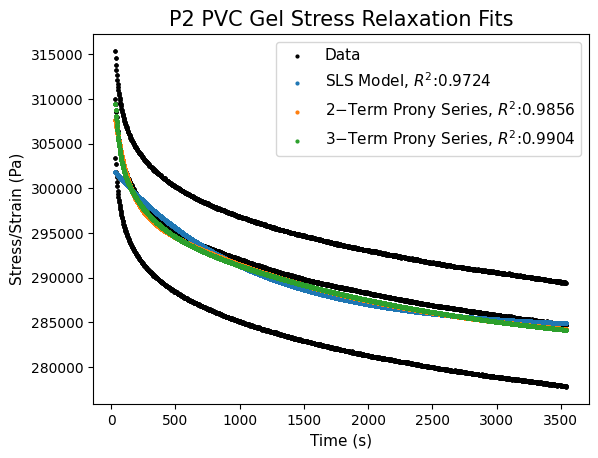

In [156]:
""" Check the smallest number of terms needed to fit the stress relaxation modulus"""
import numpy as np; import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from pvc_tensile_experiment.Functions import *

def StressRelaxFitting(modelBoundaries, plastiRatio):
    # these equations are normalized to stress/strain
    def SLS(params, t):
        EInf, E1, tau = params
        return EInf + E1*np.exp(-t/tau)

    def Prony2Term(params, t):
        EInf, E1, tau1, E2, tau2 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

    def Prony3Term(params, t):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)


    # define the model fitting function
    def FitModel(model, t, stress, boundaries):
        # define the residual function and the NRMS function
        def Residuals(params):
            return model(params, t) - stress

        def NRMS(params):
            return np.sqrt(np.mean(Residuals(params)**2))/np.mean(stress)

        # run the genetic algorithm first
        optInitialGuess = np.zeros([0, len(boundaries)])
        
        for i in range(0, 1):
            initialGuess = opt.differential_evolution(NRMS, bounds = boundaries, popsize = 600).x
            optInitialGuess = np.vstack([optInitialGuess, initialGuess])

        optParams = np.average(optInitialGuess, axis = 0)
        # optParams, _ = opt.least_squares(Residuals, optInitialGuess, method = 'lm', max_nfev = 100).x, None
    
        return optParams

    # models and initial guesses
    models = {
        "SLS Model": (SLS, modelBoundaries[0]),
        "2$-$Term Prony Series": (Prony2Term, modelBoundaries[1]), 
        "3$-$Term Prony Series": (Prony3Term, modelBoundaries[2])
        }
    
    # plot parameters
    markerSize = 4
    titleSize = 15
    axisSize = 11
    legendSize = 11

    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/Stress Relaxation Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # store the elongation regions to determine the coefficient of determination
    Data = np.zeros([0, 4])

    # define a dictionary to store the model coefficient
    fitResults = {}
    rSquared = []

    for name, (model, boundaries) in models.items():
        # determine the length of the coefficient parameters
        coefficientParameters = len(boundaries)

        # define array for the average coefficients from all datasets
        FitCoefficients = np.zeros([0, coefficientParameters])
        
        for i in fileNames:
            # read and process the data file for strain and stress 
            expTime, strain, _, stress = ViscoelasticDataProcessor('Stress Relaxation Data', i)
            
            # the starting point is 5 before the maximum stress value
            regions = StressRelaxationRegionSelector(expTime, stress)

            for j in range(1,2):
                # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
                # use these points to get the offset strain and stress
                indexRange = range(regions[0, j], regions[1, j])
                
                # get the stress vector offset
                expTimeOffset = expTime[indexRange][0]
                stressOffset = stress[indexRange][0]
                strainOffset = strain[indexRange][0]
                
                # reset the index range so the first data point is the maximum stress value.
                indexRange =  range(regions[0, j] + 5, regions[1, j])

                # define the variables 
                expTimeFit = expTime[indexRange] - expTimeOffset
                strainFit = strain[indexRange] - strainOffset
                stressFit = stress[indexRange] - stressOffset
                normStressFit = stressFit/strainFit/1.84

                # fit each data set for normalized stress
                params = FitModel(model, expTimeFit, normStressFit, boundaries)
                FitCoefficients = np.vstack([FitCoefficients, params])
                rSquared.append(RSquared(normStressFit, models[name][0](params, expTimeFit)))

                # store stress and strain into arrays for data fitting.
                Data = np.vstack([Data, np.array([expTimeFit, strainFit, stressFit, normStressFit]).T])

        # sort data based on time 
        Data = Data[Data[::, 0].argsort()]

        # show the results
        fitResults[name] = (np.mean(FitCoefficients, axis = 0), np.round(np.mean(rSquared), 4))
        print(name, fitResults[name][0], fitResults[name][1], '\n')

    # plot the fitment region
    plt.scatter(Data[::, 0], Data[::, 3], s = markerSize, c = 'black', label = f'Data')

    # preallocate data store matrices. the dictionary needs to have the data separated.
    df = pd.DataFrame(columns = ['RSquared', 'EInf', 'E1', 'Tau1', 'E2', 'Tau2', 'E3', 'Tau3'])
    data = np.zeros([0, 8], dtype = object)
    modelName = []

    # plot the model
    for name, (params, rSquared) in fitResults.items():
        # plot the fitted results
        plt.scatter(Data[::, 0], models[name][0](fitResults[name][0], Data[::, 0]), s = markerSize, label = f'{name}, $R^2$:{fitResults[name][1]}')
        plt.xlabel('Time (s)', fontsize = axisSize)
        plt.ylabel('Stress/Strain (Pa)', fontsize = axisSize)
        plt.title(f'{plastiRatio} PVC Gel Stress Relaxation Fits', fontsize = titleSize)
        plt.legend(fontsize = legendSize)

        # fill the data array for fitment
        modelName.append(name)
        params = np.hstack([np.round(params, 0), np.zeros([7 - len(params)])]) 
        data = np.vstack([data, np.insert(params, 0, np.round(rSquared, 4))])
    plt.show()


for i in ['P2']: #, 'P4','P6', 'P8']:
    if i == 'P2':
        # P2 boundaries
        modelBoundaries = list([[(1e5, 1e6), (0.5e4, 1e5), (500, 1200)], # SLS
                                [(1e5, 1e6), (0.5e4, 1e5), (1000, 2000), (1e3, 1e5), (50, 200)], # Proney 2 term
                                [(1e5, 1e6), (0.5e4, 1e5), (1000, 2200), (1e3, 1e5), (90, 500), (1e3, 1e5), (15, 60)] # Proney 3 term
                                ])
    elif i == 'P4':
        # P4 boundaries
        modelBoundaries = list([[(1e4, 5e5), (1e3, 2e4), (700, 1500)], # SLS
                                [(1e4, 5e5), (0.5e3, 1e4), (1100, 2300), (0.1e3, 1e4), (50, 200)], # Proney 2 term
                                [(1e4, 5e5), (1e3, 1e4), (1500, 2700), (1e3, 1e4), (125, 300), (1e2, 1e4), (10, 50)] # Proney 3 term
                                ])
    elif i == 'P6':
        # P6 boundaries
        modelBoundaries = list([[(1e4, 1e5), (1e2, 5e3), (400, 1000)], # SLS
                                [(1e4, 1e5), (1e2, 3e3), (1100, 2300), (1e2, 1e4), (50, 200)], # Proney 2 term
                                [(1e4, 1e5), (1e2, 3e3), (1600, 2800), (1e2, 1e4), (120, 275), (1e2, 2e4), (10, 200)] # Proney 3 term
                                ])
    else: 
        # P8 boundaries
        modelBoundaries = list([[(1e4, 5e4), (10, 1e3), (600, 1500)], # SLS
                                [(1e4, 5e4), (10, 1e3), (1000, 2300), (1e2, 1e3), (40, 220)], # Proney 2 term
                                [(1e4, 5e5), (1e2, 1.5e3), (1700, 3000), (6e1, 1e4), (60, 275), (1e2, 1e5), (35.6, 200)] # Proney 3 term
                                ]) 

    StressRelaxFitting(modelBoundaries, i)
    plt.show()

Viscoelastic Fitting

In [86]:
import numpy as np; import os; import plotly.express as px
from pvc_tensile_experiment.Functions import*
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination


def StressRelaxationData(fileNames):
    stressRelaxData = np.zeros([0, 2])

    for i in fileNames:
        # read and process the data file for strain and stress 
        expTime, strain, _, stress = ViscoelasticDataProcessor('Stress Relaxation Data', i)
        
        # the starting point is 5 before the maximum stress value
        regions = StressRelaxationRegionSelector(expTime, stress)

        for j in range(1,2):
            # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
            # use these points to get the offset strain and stress
            indexRange = range(regions[0, j], regions[1, j])
            
            # get the stress vector offset
            expTimeOffset = expTime[indexRange][0]
            stressOffset = stress[indexRange][0]
            strainOffset = strain[indexRange][0]

            # reset the index range so the first data point is the maximum stress value.
            indexRange =  range(regions[0, j] + 5, regions[1, j])

            # define the variables 
            expTimeFit = expTime[indexRange] - expTimeOffset
            strainFit = strain[indexRange] - strainOffset
            stressFit = stress[indexRange] - stressOffset
            normStressFit = stressFit/strainFit

            stressRelaxData = np.vstack([stressRelaxData, np.array([expTimeFit, normStressFit]).T])
    return stressRelaxData[:,0], stressRelaxData[:,1]

def DMAData(name, frequencyLim):
    # import the excel file. dont use columns beyond 4 since they're empty  due to 
    # needing a place to put extra comments
    df = pd.read_excel(f"Data/Viscoelastic Data/DMA Data/{name[0]}", header = 4, usecols = [0, 1, 2])
    
    # remove the first index that states units
    df.drop(0, inplace = True)

    # find indces above 5 and drop them
    indices = df[df['[rad/s]'] > frequencyLim*2*np.pi].index
    df.drop(index = indices, inplace = True)

    # convet to numpy array
    data = df.to_numpy(dtype = float)

    return data[:,0], data[:,1], data[:,2]


# ---------------- Base Class for Multi-Objective Problems ----------------
class BaseViscoProblem(ElementwiseProblem):
    def __init__(self, nVar, xl, xu):
        super().__init__(n_var = nVar, n_obj = 3, n_constr = 0, xl = xl, xu = xu)

    def StressRelaxationNMSE(self, eModel):
        # return np.sqrt(np.mean((eModel - stressRelaxation)**2))/np.mean(stressRelaxation)*100
        return np.mean(np.abs(eModel - stressRelaxation))/np.mean(stressRelaxation)*100

    def StorageModNRMSE(self, eStorageModModel):
        # return np.sqrt(np.mean((eStorageModModel - storageMod)**2))/np.mean(storageMod)*100
        return np.mean(np.abs(eStorageModModel - storageMod))/np.median(storageMod)*100

    def LossModNRMSE(self, eLossModModel):
        # return np.sqrt(np.mean((eLossModModel - lossMod)**2))/np.mean(lossMod)*100
        return np.mean(np.abs(eLossModModel - lossMod))/np.median(lossMod)*100
    
# ---------------- SLS Problem ----------------
class SlsProblem(BaseViscoProblem):
    def __init__(self):
        super().__init__(3,
                         xl = lowerBound[0:3],
                         xu = upperBound[0:3])

    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1 = x

        # Stress relaxation model
        eTimeModel = (EInf 
                      + E1*np.exp(-relaxTime/tau1))

        # DMA
        eStorageModModel = (EInf 
        + E1*(omega*tau1)**2/(1+(omega*tau1)**2))

        eLossModModel = E1*(omega*tau1)/(1+(omega*tau1)**2)

        # objective function errors
        rmseTime = self.StressRelaxationNMSE(eTimeModel)
        rmseDMA1 = self.StorageModNRMSE(eStorageModModel)
        rmseDMA2 = self.LossModNRMSE(eLossModModel)
        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]

# ---------------- 2-Term Prony Problem ----------------
class Prony2Problem(BaseViscoProblem):
    def __init__(self):
        super().__init__(5,
                         xl = lowerBound[0:5],
                         xu = upperBound[0:5])

    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1, E2, tau2 = x

        # Stress relaxation
        eTimeModel = (EInf 
        + E1*np.exp(-relaxTime/tau1) 
        + E2*np.exp(-relaxTime/tau2))

        # DMA
        eStorageModModel = (EInf 
        + E1*(omega*tau1)**2/(1+(omega*tau1)**2)
        + E2*(omega*tau2)**2/(1+(omega*tau2)**2))

        eLossModModel = (E1*(omega*tau1)/(1+(omega*tau1)**2)
        + E2*(omega*tau2)/(1+(omega*tau2)**2))
        
        # objective function errors
        rmseTime = self.StressRelaxationNMSE(eTimeModel)
        rmseDMA1 = self.StorageModNRMSE(eStorageModModel)
        rmseDMA2 = self.LossModNRMSE(eLossModModel)
        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]

# ---------------- 3-Term Prony Problem ----------------
class Prony3Problem(BaseViscoProblem):
    def __init__(self):
        super().__init__(7,
                         xl = lowerBound[0:7],
                         xu = upperBound[0:7])

    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1, E2, tau2, E3, tau3 = x

        # Stress relaxation
        eTimeModel = (EInf
        + E1*np.exp(-relaxTime/tau1)
        + E2*np.exp(-relaxTime/tau2)
        + E3*np.exp(-relaxTime/tau3))

        # DMA
        eStorageModModel = (EInf 
        + E1*(omega*tau1)**2/(1+(omega*tau1)**2)
        + E2*(omega*tau2)**2/(1+(omega*tau2)**2)
        + E3*(omega*tau3)**2/(1+(omega*tau3)**2))

        eLossModModel = (E1*(omega*tau1)/(1+(omega*tau1)**2)
        + E2*(omega*tau2)/(1+(omega*tau2)**2)
        + E3*(omega*tau3)/(1+(omega*tau3)**2))
        
        # objective function errors
        rmseTime = self.StressRelaxationNMSE(eTimeModel)
        rmseDMA1 = self.StorageModNRMSE(eStorageModModel)
        rmseDMA2 = self.LossModNRMSE(eLossModModel)
        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]
   
# ---------------- 4-Term Prony Problem ----------------
class Prony4Problem(BaseViscoProblem):
    def __init__(self):
        super().__init__(9,
                         xl = lowerBound[0:9],
                         xu = upperBound[0:9])

    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1, E2, tau2, E3, tau3, E4, tau4 = x

        # Stress relaxation
        eTimeModel = (EInf
        + E1*np.exp(-relaxTime/tau1)
        + E2*np.exp(-relaxTime/tau2)
        + E3*np.exp(-relaxTime/tau3)
        + E4*np.exp(-relaxTime/tau4))

        # DMA
        eStorageModModel = (EInf 
        + E1*(omega*tau1)**2/(1+(omega*tau1)**2)
        + E2*(omega*tau2)**2/(1+(omega*tau2)**2)
        + E3*(omega*tau3)**2/(1+(omega*tau3)**2)
        + E4*(omega*tau4)**2/(1+(omega*tau4)**2))

        eLossModModel = (E1*(omega*tau1)/(1+(omega*tau1)**2)
        + E2*(omega*tau2)/(1+(omega*tau2)**2)
        + E3*(omega*tau3)/(1+(omega*tau3)**2)
        + E4*(omega*tau4)/(1+(omega*tau4)**2))

        # objective function errors
        rmseTime = self.StressRelaxationNMSE(eTimeModel)
        rmseDMA1 = self.StorageModNRMSE(eStorageModModel)
        rmseDMA2 = self.LossModNRMSE(eLossModModel)
        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]

# ---------------- 5-Term Prony Problem ----------------
class Prony5Problem(BaseViscoProblem):
    def __init__(self):
        super().__init__(11,
                         xl = lowerBound[0:11],
                         xu = upperBound[0:11])
    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1, E2, tau2, E3, tau3, E4, tau4, E5, tau5 = x

        # Stress relaxation
        eTimeModel = (EInf
        + E1*np.exp(-relaxTime/tau1)
        + E2*np.exp(-relaxTime/tau2)
        + E3*np.exp(-relaxTime/tau3)
        + E4*np.exp(-relaxTime/tau4)
        + E5*np.exp(-relaxTime/tau5))
        
        # DMA
        eStorageModModel = (EInf 
        + E1*(omega*tau1)**2/(1+(omega*tau1)**2)
        + E2*(omega*tau2)**2/(1+(omega*tau2)**2)
        + E3*(omega*tau3)**2/(1+(omega*tau3)**2)
        + E4*(omega*tau4)**2/(1+(omega*tau4)**2)
        + E5*(omega*tau5)**2/(1+(omega*tau5)**2))

        eLossModModel = (E1*(omega*tau1)/(1+(omega*tau1)**2)
        + E2*(omega*tau2)/(1+(omega*tau2)**2)
        + E3*(omega*tau3)/(1+(omega*tau3)**2)
        + E4*(omega*tau4)/(1+(omega*tau4)**2)
        + E5*(omega*tau5)/(1+(omega*tau5)**2))
        
        # objective function errors
        rmseTime = self.StressRelaxationNMSE(eTimeModel)
        rmseDMA1 = self.StorageModNRMSE(eStorageModModel)
        rmseDMA2 = self.LossModNRMSE(eLossModModel)
        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]

# ---------------- 6-Term Prony Problem ----------------
class Prony6Problem(BaseViscoProblem):
    def __init__(self):
        super().__init__(13,
                         xl = lowerBound[0:13],
                         xu = upperBound[0:13])
    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1, E2, tau2, E3, tau3, E4, tau4, E5, tau5, E6, tau6 = x

        # Stress relaxation
        eTimeModel = (EInf
        + E1*np.exp(-relaxTime/tau1)
        + E2*np.exp(-relaxTime/tau2)
        + E3*np.exp(-relaxTime/tau3)
        + E4*np.exp(-relaxTime/tau4)
        + E5*np.exp(-relaxTime/tau5)
        + E6*np.exp(-relaxTime/tau6))
        
        # DMA
        eStorageModModel = (EInf 
        + E1*(omega*tau1)**2/(1+(omega*tau1)**2)
        + E2*(omega*tau2)**2/(1+(omega*tau2)**2)
        + E3*(omega*tau3)**2/(1+(omega*tau3)**2)
        + E4*(omega*tau4)**2/(1+(omega*tau4)**2)
        + E5*(omega*tau5)**2/(1+(omega*tau5)**2)
        + E6*(omega*tau6)**2/(1+(omega*tau6)**2))

        eLossModModel = (E1*(omega*tau1)/(1+(omega*tau1)**2)
        + E2*(omega*tau2)/(1+(omega*tau2)**2)
        + E3*(omega*tau3)/(1+(omega*tau3)**2)
        + E4*(omega*tau4)/(1+(omega*tau4)**2)
        + E5*(omega*tau5)/(1+(omega*tau5)**2)
        + E6*(omega*tau6)/(1+(omega*tau6)**2))

        # objective function errors
        rmseTime = self.StressRelaxationNMSE(eTimeModel)
        rmseDMA1 = self.StorageModNRMSE(eStorageModModel)
        rmseDMA2 = self.LossModNRMSE(eLossModModel)
        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]

# ---------------- Run Optimizations ----------------
def RunPareto(problemClass, label):
    algorithm = DNSGA2(pop_size = 1000, eliminate_duplicates = False)
    termination = MultiObjectiveSpaceTermination(tol = 0.002) # 0.002
    result = minimize(problemClass(), 
                      algorithm,
                      termination,
                      seed = 41, 
                      verbose = False)
    df = pd.DataFrame(columns = ['Stress Relaxation NMSE (%)', 'Storage Modulus NRMSE (%)',
                                                'Loss Modulus NRMSE (%)'])
    
    df['Stress Relaxation NMSE (%)'] = result.F[:,0]
    df['Storage Modulus NRMSE (%)'] = result.F[:,1]
    df['Loss Modulus NRMSE (%)'] = result.F[:,2]
    df['Model'] = label 
    return result, df


# defined boundaries
plastiRatio = 'P8'
if plastiRatio == 'P2':    #EInf    #E1      #tau1    #E2     #tau2   #E3    #tau3   #E4    #tau4   #E5    #tau5   #E6   #tau6
    lowerBound = np.array([2.8e5,   1e2,     1.8e3,   3e1,    8e1,    1e2,   1e-3,   9e1,   1e-2,   6e3,   1e-1,   0,    1e-3])
    upperBound = np.array([3.0e5,   5e4,     2.0e3,   3e4,    1e2,    7e4,   1e-2,   1e5,   1e-1,   5e4,   1e1,    3e4,  1e1])
        
elif plastiRatio == 'P4':  #EInf    #E1      #tau1    #E2    #tau2   #E3     #tau3   #E4    #tau4   #E5    #tau5   #E6   #tau6
    lowerBound = np.array([5.5e4,   1.0e3,   1.8e3,   4e2,   8e1,    4e3,    1e-3,   9e2,   1e-2,   7e2,   1e-1,   0,    1e-3])
    upperBound = np.array([5.8e4,   2.5e3,   2.0e3,   1e3,   1e2,    1.5e4,  1e-2,   7e3,   5e-1,   9e3,   1e1,    1e4,  1e1])


elif plastiRatio == 'P6':  #EInf     #E1    #tau1    #E2     #tau2   #E3     #tau3   #E4    #tau4   #E5    #tau5   #E6   #tau6
    lowerBound = np.array([2.35e4,   1e2,   1.8e3,   5e1,    8e1,    1e3,    1e-3,   3e2,   1e-2,   5e2,   1e-1,   0,    1e-3])
    upperBound = np.array([2.50e4,   1e3,   2.0e3,   6e3,    1e2,    1e4,    1e-2,   1e4,   5e-1,   1e4,   1e1,    1e4,  1e1])
   

elif plastiRatio == 'P8':  #EInf    #E1     #tau1    #E2    #tau2    #E3     #tau3   #E4    #tau4   #E5    #tau5   #E6   #tau6
    lowerBound = np.array([1.09e4,  1e2,    1.8e3,   1e2,   8e1,     1e3,    1e-3,   1e2,   1e-2,   1e1,   1e-1,   0,    1e-3])
    upperBound = np.array([1.12e4,  9e2,    2.0e3,   6e2,   1e2,     5e3,    1e-2,   3e3,   5e-1,   5e2,   1e1,    1e3,  1e1])


# locate stress relaxation data per plasticizer content. combine files for the relaxation time and stress.
fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/Stress Relaxation Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]
relaxTime, stressRelaxation = StressRelaxationData(fileNames)

# sort stress relaxation time measurements
timeSort = relaxTime.argsort()
relaxTime = relaxTime[timeSort]

# scaling offset for the DMA P2 - 1.84; P4 - 1.84, P6 - 1.8: P8 - 1.87 
stressRelaxation = stressRelaxation[timeSort]/1.87

# locate DMA data per plasticizer content
fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/DMA Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

# frequency fittment 
omega, storageMod, lossMod = DMAData(fileNames, frequencyLim = 35)

# sort DMA measurements
omegaSort = omega.argsort()
omega = omega[omegaSort]
storageMod = storageMod[omegaSort]*3#*(25**2/23**2)
lossMod = lossMod[omegaSort]*3#*(25**2/23**2)

# run multi-objective function fitment
# resSLS, dfSLS = RunPareto(SlsProblem, "SLS")
# print('SLS done')
# resP2, dfP2 = RunPareto(Prony2Problem, "Prony-2")
# print('2-term done')
resP3, dfP3 = RunPareto(Prony3Problem, "Prony-3")
print('3-term done')
resP4, dfP4 = RunPareto(Prony4Problem, "Prony-4")
print('4-term done')
resP5, dfP5 = RunPareto(Prony5Problem, "Prony-5")
print('5-term done')
resP6, dfP6 = RunPareto(Prony6Problem, "Prony-6")
print('6-term done\n\n')

# store the results into a datafram and plot using plotly
# df = pd.concat([dfSLS, dfP2, dfP3, dfP4, dfP5, dfP6], axis = 0)
# fig = px.scatter_3d(df, x = 'Stress Relaxation NMSE (%)', 
#                 y = 'Storage Modulus NRMSE (%)', z = 'Loss Modulus NRMSE (%)',
#                 title = "Pareto Fronts: Multi-Objective Fit", color = df['Model'], opacity = 0.8, size_max = 10, size = np.ones(len(df)))    
# fig.show()

KeyboardInterrupt: 

[ 0.81740858  0.8597283  27.67094572]
[0.7216883  0.4199533  5.59860048]
[0.89131973 0.27000497 1.49648753]
[0.75942573 0.26495097 1.2860485 ]


Prony-3 params: 56180.16570578727 
 [[2.46989594e+03 1.80389382e+03]
 [9.86805165e+02 9.37417860e+01]
 [8.14398070e+03 7.98495537e-03]]


Prony-4 params: 56370.56319897315 
 [[1.62202049e+03 1.84087686e+03]
 [9.99888195e+02 9.89123546e+01]
 [8.43169898e+03 5.07805725e-03]
 [2.30799632e+03 8.76938217e-02]]


Prony-5 params: 56074.43166444798 
 [[1.63647162e+03 1.80361620e+03]
 [7.82327350e+02 9.11884665e+01]
 [8.91566900e+03 3.65423453e-03]
 [2.07891744e+03 3.20216215e-02]
 [1.55665686e+03 2.91034482e-01]]


Prony-6 params: 56377.87688164145 
 [[1.45205350e+03 1.81697465e+03]
 [6.52063896e+02 9.94223927e+01]
 [8.74066755e+03 3.80006119e-03]
 [1.91791239e+03 3.19471036e-02]
 [1.53364615e+03 2.38602906e-01]
 [8.59671832e+01 6.34980093e+00]]




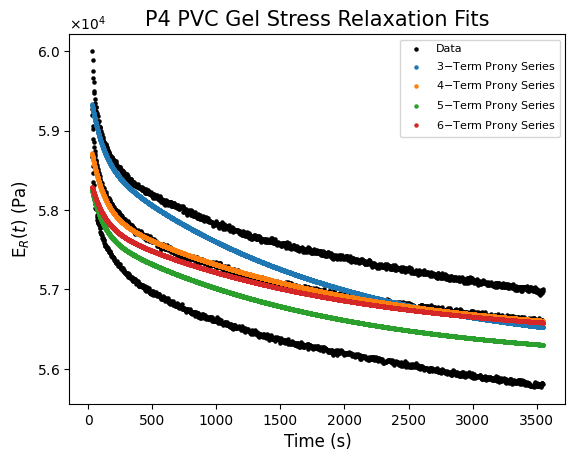

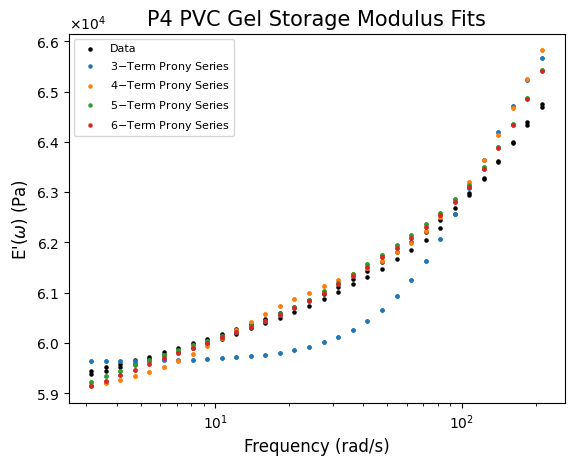

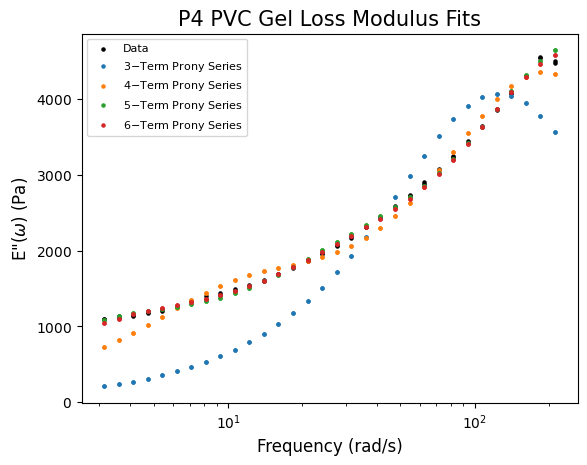

In [83]:
"""Optimal fitment plotter"""
import warnings
warnings.filterwarnings('ignore')

# define time dependent SLS and Prony series 
def SLS(params, t):
    EInf, E1, tau = params
    return EInf + E1*np.exp(-t/tau)

def Prony2Term(params, t):
    EInf, E1, tau1, E2, tau2 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

def Prony3Term(params, t):
    EInf, E1, tau1, E2, tau2, E3, tau3 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)

def Prony4Term(params, t):
    EInf, E1, tau1, E2, tau2, E3, tau3, E4, tau4 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3) + E4*np.exp(-t/tau4)

def Prony5Term(params, t):
    EInf, E1, tau1, E2, tau2, E3, tau3, E4, tau4, E5, tau5 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3) + E4*np.exp(-t/tau4) + E5*np.exp(-t/tau5)

def Prony6Term(params, t):
    EInf, E1, tau1, E2, tau2, E3, tau3, E4, tau4, E5, tau5, E6, tau6 = params
    return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3) + E4*np.exp(-t/tau4) + E5*np.exp(-t/tau5) + E6*np.exp(-relaxTime/tau6)

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)

# plotting function
def Plotter():
    # print the best results 
    # print('\n')
    # print("SLS params:", resSLS.X[fitments['SLS']][0],'\n', resSLS.X[fitments['SLS']][1::].reshape(1,2))
    # print('\n')
    # print("Prony-2 params:", resP2.X[fitments['Prony2']][0],'\n', resP2.X[fitments['Prony2']][1::].reshape(2,2))
    print('\n')
    print("Prony-3 params:", resP3.X[fitments["Prony3"]][0],'\n', resP3.X[fitments['Prony3']][1::].reshape(3,2))
    print('\n')
    print("Prony-4 params:", resP4.X[fitments["Prony4"]][0],'\n', resP4.X[fitments['Prony4']][1::].reshape(4,2))
    print('\n')
    print("Prony-5 params:", resP5.X[fitments["Prony5"]][0],'\n', resP5.X[fitments['Prony5']][1::].reshape(5,2))
    print('\n')
    print("Prony-6 params:", resP6.X[fitments["Prony6"]][0],'\n', resP6.X[fitments['Prony6']][1::].reshape(6,2))
    print('\n')

    # plot parameters
    markerSize = 5
    titleSize = 15
    axisSize = 12
    legendSize = 8

    # plot stress realxation data and fits
    plt.scatter(relaxTime, stressRelaxation, c = 'black', s = markerSize, label = 'Data')
    # plt.scatter(relaxTime, SLS(resSLS.X[fitments['SLS']], relaxTime), s = markerSize, label = 'SLS Model')
    # plt.scatter(relaxTime, Prony2Term(resP2.X[fitments["Prony2"]], relaxTime), s = markerSize, label = '2$-$Term Prony Series')
    plt.scatter(relaxTime, Prony3Term(resP3.X[fitments["Prony3"]], relaxTime), s = markerSize, label = '3$-$Term Prony Series')
    plt.scatter(relaxTime, Prony4Term(resP4.X[fitments["Prony4"]], relaxTime), s = markerSize, label = '4$-$Term Prony Series')
    plt.scatter(relaxTime, Prony5Term(resP5.X[fitments["Prony5"]], relaxTime), s = markerSize, label = '5$-$Term Prony Series')
    plt.scatter(relaxTime, Prony6Term(resP6.X[fitments["Prony6"]], relaxTime), s = markerSize, label = '6$-$Term Prony Series')


    plt.ticklabel_format(axis = 'y', style = 'sci', useMathText = True, scilimits = (0,4))
    plt.xlabel('Time (s)', fontsize = axisSize)
    plt.ylabel('E$_{R}(t)$ (Pa)', fontsize = axisSize)
    plt.title(f'{plastiRatio} PVC Gel Stress Relaxation Fits', fontsize = titleSize)
    plt.legend(fontsize = legendSize)
    plt.show()

    # plot storage modulus fits
    plt.scatter(omega, storageMod, c='black', s=markerSize, label='Data')
    # plt.scatter(omega, (resSLS.X[fitments['SLS']][0]
    #     + resSLS.X[fitments['SLS']][1]*(1j*omega*resSLS.X[fitments['SLS']][2])/(1+1j*omega*resSLS.X[fitments['SLS']][2])).real, 
    #     s = markerSize, label='SLS Model')
    # plt.scatter(omega, (resP2.X[fitments['Prony2']][0]
    #     + resP2.X[fitments['Prony2']][1]*(1j*omega*resP2.X[fitments['Prony2']][2])/(1+1j*omega*resP2.X[fitments['Prony2']][2])
    #     + resP2.X[fitments['Prony2']][3]*(1j*omega*resP2.X[fitments['Prony2']][4])/(1+1j*omega*resP2.X[fitments['Prony2']][4])).real,
    #     s = markerSize, label = '2$-$Term Prony Series')
    plt.scatter(omega, (resP3.X[fitments["Prony3"]][0]
        + resP3.X[fitments["Prony3"]][1]*(1j*omega*resP3.X[fitments["Prony3"]][2])/(1+1j*omega*resP3.X[fitments["Prony3"]][2])
        + resP3.X[fitments["Prony3"]][3]*(1j*omega*resP3.X[fitments["Prony3"]][4])/(1+1j*omega*resP3.X[fitments["Prony3"]][4])
        + resP3.X[fitments["Prony3"]][5]*(1j*omega*resP3.X[fitments["Prony3"]][6])/(1+1j*omega*resP3.X[fitments["Prony3"]][6])).real, 
        s = markerSize, label = '3$-$Term Prony Series')
    plt.scatter(omega, (resP4.X[fitments["Prony4"]][0]
        + resP4.X[fitments["Prony4"]][1]*(1j*omega*resP4.X[fitments["Prony4"]][2])/(1+1j*omega*resP4.X[fitments["Prony4"]][2])
        + resP4.X[fitments["Prony4"]][3]*(1j*omega*resP4.X[fitments["Prony4"]][4])/(1+1j*omega*resP4.X[fitments["Prony4"]][4])
        + resP4.X[fitments["Prony4"]][5]*(1j*omega*resP4.X[fitments["Prony4"]][6])/(1+1j*omega*resP4.X[fitments["Prony4"]][6])
        + resP4.X[fitments["Prony4"]][7]*(1j*omega*resP4.X[fitments["Prony4"]][8])/(1+1j*omega*resP4.X[fitments["Prony4"]][8])).real, 
        s = markerSize, label = '4$-$Term Prony Series')
    plt.scatter(omega, (resP5.X[fitments["Prony5"]][0]
        + resP5.X[fitments["Prony5"]][1]*(1j*omega*resP5.X[fitments["Prony5"]][2])/(1+1j*omega*resP5.X[fitments["Prony5"]][2])
        + resP5.X[fitments["Prony5"]][3]*(1j*omega*resP5.X[fitments["Prony5"]][4])/(1+1j*omega*resP5.X[fitments["Prony5"]][4])
        + resP5.X[fitments["Prony5"]][5]*(1j*omega*resP5.X[fitments["Prony5"]][6])/(1+1j*omega*resP5.X[fitments["Prony5"]][6])
        + resP5.X[fitments["Prony5"]][7]*(1j*omega*resP5.X[fitments["Prony5"]][8])/(1+1j*omega*resP5.X[fitments["Prony5"]][8])
        + resP5.X[fitments["Prony5"]][9]*(1j*omega*resP5.X[fitments["Prony5"]][10])/(1+1j*omega*resP5.X[fitments["Prony5"]][10])).real, 
        s = markerSize, label = '5$-$Term Prony Series')
    plt.scatter(omega, (resP6.X[fitments["Prony6"]][0]
        + resP6.X[fitments["Prony6"]][1]*(1j*omega*resP6.X[fitments["Prony6"]][2])/(1+1j*omega*resP6.X[fitments["Prony6"]][2])
        + resP6.X[fitments["Prony6"]][3]*(1j*omega*resP6.X[fitments["Prony6"]][4])/(1+1j*omega*resP6.X[fitments["Prony6"]][4])
        + resP6.X[fitments["Prony6"]][5]*(1j*omega*resP6.X[fitments["Prony6"]][6])/(1+1j*omega*resP6.X[fitments["Prony6"]][6])
        + resP6.X[fitments["Prony6"]][7]*(1j*omega*resP6.X[fitments["Prony6"]][8])/(1+1j*omega*resP6.X[fitments["Prony6"]][8])
        + resP6.X[fitments["Prony6"]][9]*(1j*omega*resP6.X[fitments["Prony6"]][10])/(1+1j*omega*resP6.X[fitments["Prony6"]][10])
        + resP6.X[fitments["Prony6"]][11]*(1j*omega*resP6.X[fitments["Prony6"]][12])/(1+1j*omega*resP6.X[fitments["Prony6"]][12])).real, 
        s = markerSize, label = '6$-$Term Prony Series')

    plt.xscale('log')
    plt.ticklabel_format(axis = 'y', style = 'sci', useMathText = True, scilimits = (0,4))
    plt.xlabel('Frequency (rad/s)', fontsize = axisSize)
    plt.ylabel('E\'($\omega$) (Pa)', fontsize = axisSize)
    plt.title(f'{plastiRatio} PVC Gel Storage Modulus Fits', fontsize = titleSize)
    plt.legend(fontsize = legendSize)
    plt.show()


    # plot loss modulus fits
    plt.scatter(omega, lossMod, c = 'black', s = markerSize, label='Data')
    # plt.scatter(omega, (resSLS.X[fitments['SLS']][0]
    #     + resSLS.X[fitments['SLS']][1]*(1j*omega*resSLS.X[fitments['SLS']][2])/(1+1j*omega*resSLS.X[fitments['SLS']][2])).imag,
    #     s = markerSize, label='SLS Model')
    # plt.scatter(omega, (resP2.X[fitments['Prony2']][0]
    #     + resP2.X[fitments['Prony2']][1]*(1j*omega*resP2.X[fitments['Prony2']][2])/(1+1j*omega*resP2.X[fitments['Prony2']][2])
    #     + resP2.X[fitments['Prony2']][3]*(1j*omega*resP2.X[fitments['Prony2']][4])/(1+1j*omega*resP2.X[fitments['Prony2']][4])).imag,
    #     s = markerSize, label = '2$-$Term Prony Series')
    plt.scatter(omega, (resP3.X[fitments["Prony3"]][0]
        + resP3.X[fitments["Prony3"]][1]*(1j*omega*resP3.X[fitments["Prony3"]][2])/(1+1j*omega*resP3.X[fitments["Prony3"]][2])
        + resP3.X[fitments["Prony3"]][3]*(1j*omega*resP3.X[fitments["Prony3"]][4])/(1+1j*omega*resP3.X[fitments["Prony3"]][4])
        + resP3.X[fitments["Prony3"]][5]*(1j*omega*resP3.X[fitments["Prony3"]][6])/(1+1j*omega*resP3.X[fitments["Prony3"]][6])).imag,
        s = markerSize, label = '3$-$Term Prony Series')
    plt.scatter(omega, (resP4.X[fitments["Prony4"]][0]
        + resP4.X[fitments["Prony4"]][1]*(1j*omega*resP4.X[fitments["Prony4"]][2])/(1+1j*omega*resP4.X[fitments["Prony4"]][2])
        + resP4.X[fitments["Prony4"]][3]*(1j*omega*resP4.X[fitments["Prony4"]][4])/(1+1j*omega*resP4.X[fitments["Prony4"]][4])
        + resP4.X[fitments["Prony4"]][5]*(1j*omega*resP4.X[fitments["Prony4"]][6])/(1+1j*omega*resP4.X[fitments["Prony4"]][6])
        + resP4.X[fitments["Prony4"]][7]*(1j*omega*resP4.X[fitments["Prony4"]][8])/(1+1j*omega*resP4.X[fitments["Prony4"]][8])).imag,
        s = markerSize, label = '4$-$Term Prony Series')
    plt.scatter(omega, (resP5.X[fitments["Prony5"]][0]
        + resP5.X[fitments["Prony5"]][1]*(1j*omega*resP5.X[fitments["Prony5"]][2])/(1+1j*omega*resP5.X[fitments["Prony5"]][2])
        + resP5.X[fitments["Prony5"]][3]*(1j*omega*resP5.X[fitments["Prony5"]][4])/(1+1j*omega*resP5.X[fitments["Prony5"]][4])
        + resP5.X[fitments["Prony5"]][5]*(1j*omega*resP5.X[fitments["Prony5"]][6])/(1+1j*omega*resP5.X[fitments["Prony5"]][6])
        + resP5.X[fitments["Prony5"]][7]*(1j*omega*resP5.X[fitments["Prony5"]][8])/(1+1j*omega*resP5.X[fitments["Prony5"]][8])
        + resP5.X[fitments["Prony5"]][9]*(1j*omega*resP5.X[fitments["Prony5"]][10])/(1+1j*omega*resP5.X[fitments["Prony5"]][10])).imag,
        s = markerSize, label = '5$-$Term Prony Series')
    plt.scatter(omega, (resP6.X[fitments["Prony6"]][0]
        + resP6.X[fitments["Prony6"]][1]*(1j*omega*resP6.X[fitments["Prony6"]][2])/(1+1j*omega*resP6.X[fitments["Prony6"]][2])
        + resP6.X[fitments["Prony6"]][3]*(1j*omega*resP6.X[fitments["Prony6"]][4])/(1+1j*omega*resP6.X[fitments["Prony6"]][4])
        + resP6.X[fitments["Prony6"]][5]*(1j*omega*resP6.X[fitments["Prony6"]][6])/(1+1j*omega*resP6.X[fitments["Prony6"]][6])
        + resP6.X[fitments["Prony6"]][7]*(1j*omega*resP6.X[fitments["Prony6"]][8])/(1+1j*omega*resP6.X[fitments["Prony6"]][8])
        + resP6.X[fitments["Prony6"]][9]*(1j*omega*resP6.X[fitments["Prony6"]][10])/(1+1j*omega*resP6.X[fitments["Prony6"]][10])
        + resP6.X[fitments["Prony6"]][11]*(1j*omega*resP6.X[fitments["Prony6"]][12])/(1+1j*omega*resP6.X[fitments["Prony6"]][12])).imag, 
        s = markerSize, label = '6$-$Term Prony Series')
    
    plt.xscale('log')
    plt.ticklabel_format(axis = 'y', style = 'sci', useMathText = True, scilimits = (0,4))
    plt.xlabel('Frequency (rad/s)', fontsize = axisSize)
    plt.ylabel('E\"($\omega$) (Pa)', fontsize = axisSize)
    plt.title(f'{plastiRatio} PVC Gel Loss Modulus Fits', fontsize = titleSize)
    plt.legend(fontsize = legendSize)
    plt.show()

# store the fitted results in a dictionary
fitments = {#'SLS': resSLS,
            #'Prony2': resP2,
            'Prony3': resP3,
            'Prony4': resP4,
            'Prony5': resP5,
            'Prony6': resP6}

# find the best results and store the index of each 
for name, fit in fitments.items():
    F = fit.F
    scores = 1*F[:,0] + 1.0*F[:,1] + 1.0*F[:,2]

    fitments[name] = int(np.argmin(scores))
    print(F[fitments[name]])
Plotter()

In [85]:
"""Save the viscoelastic parameters"""
# recreate the fitments dictionary from the results
fitments = {#'SLS': resSLS,
            #'Prony2': resP2,
            'Prony3': resP3,
            'Prony4': resP4,
            'Prony5': resP5,
            'Prony6': resP6}

# preallocate a list for the names and parameters
modelName = []
data = np.zeros([0, 16], dtype = object)

# find the best result nad their errors and store in the data matrix 
for name, fit in fitments.items():
    F = fit.F
    scores = 1.0*F[:,0] + 1.0*F[:,1] + 1.0*F[:,2] 

    index = int(np.argmin(scores))
    size = len(fitments[name].X[index])

    data = np.vstack([data,np.hstack([F[index], fitments[name].X[index], np.zeros([13 - size])])])
    modelName.append(name)

# convert the data matrix to a dataframe and save them
df = pd.DataFrame(data, columns = ['Stress Relaxation NMSE', 'Storage Modulus NMSE', 'Loss Modulus NMSE', 'EInf', 'E1', 'Tau1', 'E2', 'Tau2', 'E3', 'Tau3', 'E4', 'Tau4', 'E5', 'Tau5', 'E6', 'Tau6'])
df.insert(0, 'Models', modelName)
df.to_csv(f'Data/{plastiRatio} PVC Gel Viscoelastic Parameters.csv', header = True, index = None)



_______

DMA Data Viewer

In [ ]:
import matplotlib.pyplot as plt
import os; import pandas as pd

def DMADataProcessor(name):
    # import the excel file. dont use columns beyond 4 since they're empty  due to 
    # needing a place to put extra comments
    df = pd.read_excel(f"Data/Viscoelastic Data/DMA Data/{name[0]}", header = 34)
    
    # remove the first index that states units
    df.drop(0, inplace = True)

    # find indces above 5 and drop them
    indices = df[df['Freq.'] > 5].index
    df.drop(index = indices, inplace = True)

    # convet to numpy array
    data = df.to_numpy(dtype = float)

    frequency = data[:, 0]                  # frequency (Hz)
    storageModulus = data[:, 2]             # storage modulus (Pa)
    lossModulus = data[:, 3]                # loss modulus (Pa)
    lossFactor = data[:, 4]                 # loss factor (rad)
    return frequency, storageModulus/1.8, lossModulus/1.8, lossFactor


# plot parameters
markerSize = 4
titleSize = 15
axisSize = 12
legendSize = 10

# preallocate figure and parameters
fig, ax1 = plt.subplots()
ax1.set_xlabel('Frequency (Hz)', fontsize = axisSize)
ax1.set_ylabel('Storage Modulus (Pa)', fontsize = axisSize)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss Modulus (Pa)', fontsize = axisSize)
plt.xscale('log')

for plastiRatio in ['P8']:

    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/DMA Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]
    print(fileNames)

    frequency, storageModulus, lossModulus, lossFactor = DMADataProcessor(fileNames)

    # You can also plot the results to visualize the frequency response
    ax1.scatter(frequency, storageModulus, label = "Storage Modulus (E')")
    ax2.scatter(frequency, lossModulus, s = 5, label = "Loss Modulus (E'')", c = 'tab:orange')
    ax1.legend(loc = 0)
    ax2.legend(loc = 0)
    ax1.grid(True, which="both", ls="--")
    ax1.set_title(f'{plastiRatio} PVC Storage and Loss Modululs')
    plt.show()
    

Concentration Dependance

In [ ]:
from pvc_tensile_experiment.Functions import *
import pandas as pd; import numpy as np
from scipy.optimize import curve_fit

def LinearFit(x, a, b):
    return a*x + b

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)



# find the names of the viscoelastic functions
fileNames = [i for i in os.listdir('Data') if i.endswith('.csv')][0:-1]

# make the  concentrations repeat 3 times. one for each modulus.
concentration = np.repeat([np.array([2, 4, 6, 8])], 3)
# concentration = np.repeat(np.array([25.6, 14.6, 10.3, 7.9]), 3)


# preallocate the data dataframe
data = pd.DataFrame(columns = ['Models', 'EInf', 'E1', 'E2', 'E3'])
for i in fileNames:
    # read the modulus from each model, ignoring the time constants. 
    # add to the data dataframe
    modulus = pd.read_csv(f'Data/{i}', usecols = [0, 2, 3, 5, 7])
    data = pd.concat([data, modulus], ignore_index = True)

# convert each modulus to log base 10. convert -inf to empty
data['EInf'] = data['EInf']
data['E1'] = data['E1']
data['E2'] = data['E2']
data['E3'] = data['E3']
data.replace([np.inf, -np.inf], np.empty, inplace = True)

# add a concentration column 
data.insert(0, 'Plasticizer', concentration)

# plot parameters
markerSize = 10
titleSize = 15
axisSize = 12
legendSize = 11

# identify each model
SLSModel = data[data['Models'] == 'SLS Model']
Proney2TermModel = data[data['Models'] == 'Prony 2-Term Model']
Proney3TermModel = data[data['Models'] == 'Prony 3-Term Model']

# create a dictionary to fit the modulus
models = {'EInf': Proney3TermModel['EInf'],
          'E1': Proney3TermModel['E1'],
          'E2': Proney3TermModel['E2'],
          'E3': Proney3TermModel['E3'],
          }

# create a dictionary to story the fitted modulus
fitResults = {}

for term, (values) in models.items():
    params, _ = curve_fit(LinearFit, np.log10(Proney3TermModel['Plasticizer'].to_numpy()), np.log10(values))
    print()
    r2 = RSquared(np.log10(values), LinearFit(np.log10(Proney3TermModel['Plasticizer'].to_numpy()), params[0], params[1]))
    fitResults[term] = (params, r2)

plt.xscale('log')
plt.yscale('log')

# Proney3TermModel model evaluation.
plt.scatter(Proney3TermModel['Plasticizer'], Proney3TermModel['EInf'], s = markerSize, label = f'E$_I$$_n$$_f$-slope = {np.round(fitResults['EInf'][0][0], 3)}, r$^2$ = {np.round(fitResults['EInf'][1], 4)}')
plt.plot(Proney3TermModel['Plasticizer'], np.power(10, LinearFit(np.log10(Proney3TermModel['Plasticizer'].to_numpy()), fitResults['EInf'][0][0], fitResults['EInf'][0][1])), linewidth = 1)

plt.scatter(Proney3TermModel['Plasticizer'], Proney3TermModel['E1'], s = markerSize, label = f'E$_1$-slope = {np.round(fitResults['E1'][0][0], 3)}, r$^2$ = {np.round(fitResults['E1'][1], 3)}')
plt.plot(Proney3TermModel['Plasticizer'], np.power(10, LinearFit(np.log10(Proney3TermModel['Plasticizer'].to_numpy()), fitResults['E1'][0][0], fitResults['E1'][0][1])), linewidth = 1)

plt.scatter(Proney3TermModel['Plasticizer'], Proney3TermModel['E2'], s = markerSize, label = f'E$_2$-slope = {np.round(fitResults['E2'][0][0], 3)}, r$^2$ = {np.round(fitResults['E2'][1], 3)}')
plt.plot(Proney3TermModel['Plasticizer'], np.power(10, LinearFit(np.log10(Proney3TermModel['Plasticizer'].to_numpy()), fitResults['E2'][0][0], fitResults['E2'][0][1])), linewidth = 1)

plt.scatter(Proney3TermModel['Plasticizer'], Proney3TermModel['E3'], s = markerSize, label = f'E$_3$-slope = {np.round(fitResults['E3'][0][0], 3)}, r$^2$ = {np.round(fitResults['E3'][1], 3)}')
plt.plot(Proney3TermModel['Plasticizer'], np.power(10, LinearFit(np.log10(Proney3TermModel['Plasticizer'].to_numpy()), fitResults['E3'][0][0], fitResults['E3'][0][1])), linewidth = 1)

# plot settings
plt.xlabel('Volume Concentration (%)', fontsize = axisSize)
plt.title('Prony Series Modulus - PVC Volume Concentration', fontsize = titleSize)

plt.xlabel('Weight Ratio', fontsize = axisSize)
plt.title('Prony Series Modulus - Plasticizer Weight Ratio', fontsize = titleSize)

plt.ylabel('Modulus (Pa)', fontsize = axisSize)
plt.legend(fontsize = legendSize)


 ___________

MISC Functions

Visoelastic Total/Grouped Data Viewer

In [ ]:
"""This function shows data grouped by plasticizer content"""
from pvc_tensile_experiment.Functions import *
def MonotonicDataViewer(plastiRatio):
    # define the folder name and pull the files that end with xlsx
    folderName = 'Monotonic Strain Rate Data'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # plot parameters
    markerSize = 4
    titleSize = 15
    axisSize = 12
    legendSize = 11

    # preallocate lists to store all the strain and stress per plasticizer content
    totalStrain = np.array(0)
    totalStress = np.array(0)

    for i in fileNames:
        # read and process the data file for strain and stress 
        _, strain, _, stress = ViscoelasticDataProcessor(folderName, i)

        # find each strain amplitude region
        regions = MonotonicStrainRateRegionSelector(strain)
        for j in range(0, 3):
            indexRange = range(regions[0, j], regions[1, j])
            strainFit = strain[indexRange] - strain[indexRange][0]
            stressFit = stress[indexRange] 

            totalStrain = np.hstack([totalStrain, strainFit])
            totalStress = np.hstack([totalStress, stressFit])

    # index = np.where(totlalStrain < 0.05)[0]
    plt.scatter(totalStrain, totalStress/np.max(totalStress), s = markerSize, label = f'{plastiRatio}')
    plt.xlabel('Strain (m/m)', fontsize = axisSize)
    plt.ylabel('Normalized Stress (Pa)', fontsize = axisSize)
    plt.title('Time Delay Between Strain Segments', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

def RelaxationDataViewer(plastiRatio):
    # define the folder name and pull the files that end with xlsx
    folderName = 'Stress Relaxation Data'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # plot parameters
    markerSize = 4
    titleSize = 15
    axisSize = 12
    legendSize = 11

    # preallocate lists to store all the strain and stress per plasticizer content
    totalTime = np.array(0)
    totalNormStress = np.array(0)

    for i in fileNames:
        # read and process the data file for strain and stress 
        expTime, strain, _, stress = ViscoelasticDataProcessor(folderName, i)

        # the starting point is 4 before the maximum stress value
        regions = StressRelaxationRegionSelector(expTime, stress)

        for j in range(0, 2): 
            # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
            # use these points to get the offset strain and stress
            indexRange = range(regions[0, j], regions[1, j])
            
            # get the stress vector offset
            expTimeOffset = expTime[indexRange][0]
            stressOffset = stress[indexRange][0]
            strainOffset = strain[indexRange][0]
            
            # reset the index range so the first data point is the maximum stress value.
            indexRange =  range(regions[0, j] + 5, regions[1, j])

            # define the variables 
            expTimeFit = expTime[indexRange] - expTimeOffset
            strainFit = strain[indexRange] - strainOffset
            stressFit = stress[indexRange] - stressOffset
            normStressFit = stressFit/strainFit

            totalTime = np.hstack([totalTime, expTimeFit])
            totalNormStress = np.hstack([totalNormStress, normStressFit])

    plt.scatter(totalTime, totalNormStress, s = markerSize, label = f'{plastiRatio}')

    plt.xlabel('Time (s)', fontsize = axisSize)
    plt.ylabel('Stress/Strain (Pa)', fontsize = axisSize)
    plt.title('Normalized Stress Relaxation Fitting Region', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

# for plastiRatio in ['P2', 'P4', 'P6', 'P8']:
#    MonotonicDataViewer(plastiRatio)
# plt.show()

for plastiRatio in ['P4']:
    RelaxationDataViewer(plastiRatio)
plt.show()

Stress Relaxation Region Selector Verification

In [ ]:
import numpy as np; import os
from pvc_tensile_experiment.Functions import *

# define the folder name and pull the files that end with xlsx
folderName = 'Stress Relaxation Data'
fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx')]

# plot parameters
markerSize = 4
titleSize = 15
axisSize = 12
legendSize = 10

for i in fileNames:
    # read and process the data file for strain and stress 
    expTime, strain, _, stress = ViscoelasticDataProcessor(folderName, i)

    # the starting point is 4 before the maximum stress value
    regions = StressRelaxationRegionSelector(expTime, stress)
    
    for j in range(0, 3): 
        # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
        # use these points to get the offset strain and stress
        indexRange = range(regions[0, j], regions[1, j])
        plt.scatter(expTime[indexRange[0]], stress[indexRange[0]], s = 20, c = 'black')

        # get the stress vector offset
        expTimeOffset = expTime[indexRange][0]
        stressOffset = stress[indexRange][0]
        strainOffset = strain[indexRange][0]
        
        # reset the index range so the first data point is the maximum stress value.
        indexRange =  range(regions[0, j] + 5, regions[1, j])

        # define the variables 
        expTimeFit = expTime[indexRange] - expTimeOffset
        strainFit = strain[indexRange] - strainOffset
        stressFit = stress[indexRange] - stressOffset
        normStressFit = stressFit/strainFit

        plt.scatter(expTime, stress, s = markerSize, c = 'tab:blue')
        plt.scatter(expTime[indexRange[0]], stress[indexRange[0]], s = 15, c = 'tab:red')
        plt.scatter(expTime[indexRange[-1]], stress[indexRange[-1]], s = 15, c = 'tab:red')
    plt.show()

Hysteresis

In [ ]:
"""This shows the hysteresis of a plasticizer"""
from pvc_tensile_experiment.Functions import *
def HysteresisDataViewer(plastiRatio):
    # define the folder name and pull the files that end with xlsx
    folderName = 'Monotonic Strain Rate Data'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # plot parameters
    markerSize = 4
    titleSize = 15
    axisSize = 11
    legendSize = 9

    for i in fileNames:
        # read and process the data file for strain and stress 
        _, strain, _, stress = ViscoelasticDataProcessor(folderName, i)

        # find each strain amplitude region
        regions = MonotonicStrainRateRegionSelector(strain)
        for j in range(2, 3):
            indexRange = range(regions[0, j], regions[1, j] +  regions[1, j] - regions[0, j] + 7)
            strainFit = strain[indexRange] - strain[indexRange][0]
            stressFit = stress[indexRange] - stress[indexRange[0]]
            plt.plot(strainFit, stressFit, label = f' Trial: {i.removesuffix('.xlsx').split('_')[1]}')
    
    
    plt.xlabel('Strain (m/m)', fontsize = axisSize)
    plt.ylabel('Stress (Pa)', fontsize = axisSize)
    plt.title(f'{plastiRatio} Hysteresis at 30% Strain', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

for plastiRatio in ['P2']:# 'P4', 'P6', 'P8']:
   HysteresisDataViewer(plastiRatio)
plt.show()

Stress Relaxation Fitting and Monotonic Stress Verification

In [ ]:
"""We use the normalized stress relaxation to fit the coefficeints of the 
    SLS and proney series then verify results using the monotonic strain 
    rate data"""
import numpy as np; import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from pvc_tensile_experiment.Functions import *

def StressRelaxFitting(modelBoundaries, plastiRatio):
    # these equations are normalized to stress/strain
    def SLS(params, t):
        EInf, E1, tau = params
        return EInf + E1*np.exp(-t/tau)

    def Prony2Term(params, t):
        EInf, E1, tau1, E2, tau2 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

    def Prony3Term(params, t):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)


    # define the model fitting function
    def FitModel(model, t, stress, boundaries):
        # define the residual function and the NRMS function
        def Residuals(params):
            return model(params, t) - stress

        def NRMS(params):
            return np.sqrt(np.mean(Residuals(params)**2))/np.mean(stress)

        # run the genetic algorithm first
        optInitialGuess = np.zeros([0, len(boundaries)])
        
        for i in range(0, 5):
            initialGuess = opt.differential_evolution(NRMS, bounds = boundaries, popsize = 75).x
            optInitialGuess = np.vstack([optInitialGuess, initialGuess])

        # average the genetic algorithm then pass results to the LM method
        optParams = np.average(optInitialGuess, axis = 0)

        # optInitialGuess = np.average(optInitialGuess, axis = 0)
        # # print(f'initial parms {optInitialGuess}')
        # optParams, _ = opt.least_squares(Residuals, optInitialGuess, method = 'trf', max_nfev = 100).x, None
    
        return optParams

    # models and initial guesses
    models = {
        "SLS Model": (SLS, modelBoundaries[0]),
        "Prony 2-Term Model": (Prony2Term, modelBoundaries[1]), 
        "Prony 3-Term Model": (Prony3Term, modelBoundaries[2])
        }
    
    # plot parameters
    markerSize = 4
    titleSize = 15
    axisSize = 11
    legendSize = 11

    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/Stress Relaxation Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # store the elongation regions to determine the coefficient of determination
    Data = np.zeros([0, 4])

    # define a dictionary to store the model coefficient
    fitResults = {}
    rSquared = []

    for name, (model, boundaries) in models.items():
        # determine the length of the coefficient parameters
        coefficientParameters = len(boundaries)

        # define array for the average coefficients from all datasets
        FitCoefficients = np.zeros([0, coefficientParameters])
        
        for i in fileNames:
            # read and process the data file for strain and stress 
            expTime, strain, _, stress = ViscoelasticDataProcessor('Stress Relaxation Data', i)
            
            # the starting point is 5 before the maximum stress value
            regions = StressRelaxationRegionSelector(expTime, stress)

            for j in range(0, 3):
                # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
                # use these points to get the offset strain and stress
                indexRange = range(regions[0, j], regions[1, j])
                
                # get the stress vector offset
                expTimeOffset = expTime[indexRange][0]
                stressOffset = stress[indexRange][0]
                strainOffset = strain[indexRange][0]
                
                # reset the index range so the first data point is the maximum stress value.
                indexRange =  range(regions[0, j] + 5, regions[1, j])

                # define the variables 
                expTimeFit = expTime[indexRange] - expTimeOffset
                strainFit = strain[indexRange] - strainOffset
                stressFit = stress[indexRange] - stressOffset
                normStressFit = stressFit/strainFit/1.9

                # fit each data set for normalized stress
                params = FitModel(model, expTimeFit, normStressFit, boundaries)
                FitCoefficients = np.vstack([FitCoefficients, params])
                rSquared.append(RSquared(normStressFit, models[name][0](params, expTimeFit)))

                # store stress and strain into arrays for data fitting.
                Data = np.vstack([Data, np.array([expTimeFit, strainFit, stressFit, normStressFit]).T])

        # sort data based on time 
        Data = Data[Data[::, 0].argsort()]

        # show the results
        fitResults[name] = (np.mean(FitCoefficients, axis = 0), np.round(np.mean(rSquared), 4))
        print(name, fitResults[name][0], fitResults[name][1], '\n')

    # plot the fitment region
    plt.scatter(Data[::, 0], Data[::, 3], s = markerSize, label = f'{plastiRatio} Test Data')

    # preallocate data store matrices. the dictionary needs to have the data separated.
    df = pd.DataFrame(columns = ['RSquared', 'EInf', 'E1', 'Tau1', 'E2', 'Tau2', 'E3', 'Tau3'])
    data = np.zeros([0, 8], dtype = object)
    modelName = []

    # plot the model
    for name, (params, rSquared) in fitResults.items():
        # plot the fitted results
        plt.scatter(Data[::, 0], models[name][0](fitResults[name][0], Data[::, 0]), s = markerSize, label = f'{name}, $R^2$:{fitResults[name][1]}')
        plt.xlabel('Time (s)', fontsize = axisSize)
        plt.ylabel('Stress/Strain (Pa)', fontsize = axisSize)
        plt.title(f'{plastiRatio} Fitment', fontsize = titleSize)
        plt.legend(fontsize = legendSize)

        # fill the data array for fitment
        modelName.append(name)
        params = np.hstack([np.round(params, 0), np.zeros([7 - len(params)])]) 
        data = np.vstack([data, np.insert(params, 0, np.round(rSquared, 4))])
    plt.show()

    # populate the dataframe and save the data in csv
    df = pd.DataFrame(data, columns = ['RSquared', 'EInf', 'E1', 'Tau1', 'E2', 'Tau2', 'E3', 'Tau3'])
    df.insert(0, 'Models', modelName)
    df.to_csv(f'Data/{plastiRatio} PVC Gel Viscoelastic Parameters.csv', header = True, index = None)


def MonotonicStressVerification(plastiRatio):

    # define the SLS, Prony series, and coefficient of determination functions
    # these are in terms of stress
    def SLSStrainRate(params, strain):
        EInf, E1, tau = params
        return EInf*strain + E1*tau*strainRateFit*(1 - np.exp(-strain/(tau*strainRateFit))) 

    def Prony2TermStrainRate(params, strain):
        EInf, E1, tau1, E2, tau2 = params

        return (EInf*strain +
                E1*tau1*strainRateFit*(1 - np.exp(-strain/(tau1*strainRateFit))) +
                E2*tau2*strainRateFit*(1 - np.exp(-strain/(tau2*strainRateFit))))

    def Prony3TermStrainRate(params, strain):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return (EInf*strain +
                E1*tau1*strainRateFit*(1 - np.exp(-strain/(tau1*strainRateFit))) +
                E2*tau2*strainRateFit*(1 - np.exp(-strain/(tau2*strainRateFit))) +
                E3*tau3*strainRateFit*(1 - np.exp(-strain/(tau3*strainRateFit))))

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)


    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir('Data/Viscoelastic Data/Monotonic Strain Rate Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # store the elongation regions to determine the coefficient of determination
    Data = np.zeros([0, 3])

    # plot parameters
    markerSize = 4
    titleSize = 15
    axisSize = 11
    legendSize = 11

    # read each file, extracting the increasing strain region and save all to a set of arrays
    for i in fileNames:
        # read and process the data file for strain and stress 
        _, strain, strainRate, stress = ViscoelasticDataProcessor('Monotonic Strain Rate Data', i)

        # find each strain amplitude region
        regions = MonotonicStrainRateRegionSelector(strain)
        
        for j in range(0, 3):
            # extract the increasing strain regions
            indexRange = range(regions[0, j], regions[1, j])
            strainFit = strain[indexRange] - strain[indexRange][0]
            strainRateFit = strainRate[indexRange]
            stressFit = stress[indexRange] - stress[indexRange][0]

            # store stress and strain into arrays for data fitting.
            Data = np.vstack([Data, np.array([strainFit, strainRateFit, stressFit]).T])

    # reorganize the data
    Data = Data[Data[::, 0].argsort()]

    # define the strain rate fit for the functions
    strainRateFit = Data[::, 1]

    # plot data results
    plt.scatter(Data[::, 0], Data[::, 2], s = markerSize, color = "black", label = f'{plastiRatio} Data')

    # find the coefficients for each equation
    fileNames = [i for i in os.listdir('Data/') if i.endswith('.csv') and i.find(plastiRatio) != -1][0]
    fitResults = pd.read_csv(f"Data/{fileNames}").to_numpy()

    # models and initial guesses
    models = {
        "SLS Model": (SLSStrainRate, fitResults[0, np.nonzero(fitResults[0,:])[0]][2:]),
        "Prony 2-Term Model": (Prony2TermStrainRate, fitResults[1, np.nonzero(fitResults[1,:])[0]][2:]), 
        "Prony 3-Term Model": (Prony3TermStrainRate, fitResults[2, np.nonzero(fitResults[2,:])[0]][2:])
        }

    for name, (modelEqu, params) in models.items():
        plt.scatter(Data[::, 0], modelEqu(params, Data[::, 0]), s = markerSize, label = f'{name}, $R^2$:{np.round(RSquared(Data[::, 2], modelEqu(params, Data[::, 0])), 4)}')
        plt.xlabel('Strain (m/m)', fontsize = axisSize)
        plt.ylabel('Stress (Pa)', fontsize = axisSize)
        plt.title(f'{plastiRatio} Monotonic Strain Fitment', fontsize = titleSize)
        plt.legend(fontsize = legendSize)


for i in ['P2', 'P4','P6', 'P8']:
    if i == 'P2':
        # P2 boundaries
        modelBoundaries = list([[(1e5, 1e6), (0.5e4, 1e5), (500, 1200)], # SLS
                                [(1e5, 1e6), (0.5e4, 1e5), (1000, 2000), (1e3, 1e5), (50, 200)], # Proney 2 term
                                [(1e5, 1e6), (0.5e4, 1e5), (1000, 2200), (1e3, 1e5), (90, 500), (1e3, 1e5), (15, 60)] # Proney 3 term
                                ])
    elif i == 'P4':
        # P4 boundaries
        modelBoundaries = list([[(1e4, 5e5), (1e3, 2e4), (700, 1500)], # SLS
                                [(1e4, 5e5), (0.5e3, 1e4), (1100, 2300), (0.1e3, 1e4), (50, 200)], # Proney 2 term
                                [(1e4, 5e5), (1e3, 1e4), (1500, 2700), (1e3, 1e4), (125, 300), (1e2, 1e4), (10, 50)] # Proney 3 term
                                ])
    elif i == 'P6':
        # P6 boundaries
        modelBoundaries = list([[(1e4, 1e5), (1e2, 5e3), (400, 1000)], # SLS
                                [(1e4, 1e5), (1e2, 3e3), (1100, 2300), (1e2, 1e4), (50, 200)], # Proney 2 term
                                [(1e4, 1e5), (1e2, 3e3), (1600, 2800), (1e2, 1e4), (120, 275), (1e3, 2e4), (100, 200)] # Proney 3 term
                                ])
    else: 
        # P8 boundaries
        modelBoundaries = list([[(1e4, 5e4), (10, 1e3), (600, 1500)], # SLS
                                [(1e4, 5e4), (10, 1e3), (1000, 2300), (1e2, 1e3), (40, 220)], # Proney 2 term
                                [(1e4, 5e5), (1e2, 1.5e3), (1700, 3000), (1e2, 1e4), (125, 275), (1e3, 1e5), (100, 200)] # Proney 3 term
                                ]) 

    StressRelaxFitting(modelBoundaries, i)
    plt.show()
    MonotonicStressVerification(i)
    plt.show()

Viscoelastic Fitting with Time Constant Penalty

In [ ]:
import numpy as np; import os; import plotly.express as px
import pandas as pd
from pvc_tensile_experiment.Functions import*
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.dnsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.repair.bounds_repair import BoundsRepair


def StressRelaxationData(fileNames):
    stressRelaxData = np.zeros([0, 2])

    for i in fileNames:
        # read and process the data file for strain and stress 
        expTime, strain, _, stress = ViscoelasticDataProcessor('Stress Relaxation Data', i)
        
        # the starting point is 5 before the maximum stress value
        regions = StressRelaxationRegionSelector(expTime, stress)

        for j in range(1,2):
            # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
            # use these points to get the offset strain and stress
            indexRange = range(regions[0, j], regions[1, j])
            
            # get the stress vector offset
            expTimeOffset = expTime[indexRange][0]
            stressOffset = stress[indexRange][0]
            strainOffset = strain[indexRange][0]

            # reset the index range so the first data point is the maximum stress value.
            indexRange =  range(regions[0, j] + 5, regions[1, j])

            # define the variables 
            expTimeFit = expTime[indexRange] - expTimeOffset
            strainFit = strain[indexRange] - strainOffset
            stressFit = stress[indexRange] - stressOffset
            normStressFit = stressFit/strainFit/1.85

            stressRelaxData = np.vstack([stressRelaxData, np.array([expTimeFit, normStressFit]).T])
    return stressRelaxData[:,0], stressRelaxData[:,1]

def DMAData(name):
    # import the excel file. dont use columns beyond 4 since they're empty  due to 
    # needing a place to put extra comments
    df = pd.read_excel(f"Data/Viscoelastic Data/DMA Data/{name[0]}", header = 33, usecols = [0, 2, 3])

    # remove the first index that states units
    df.drop(0, inplace = True)

    # find indces above 5 and drop them
    indices = df[df['Freq.'] > 40].index
    df.drop(index = indices, inplace = True)

    # convet to numpy array
    data = df.to_numpy(dtype = float)

    return data[:,0], data[:,1], data[:,2]

# ---------------- Base Class for Multi-Objective Problems ----------------
class BaseViscoProblem(ElementwiseProblem):
    def __init__(self, nVar, xl, xu):
        super().__init__(n_var = nVar, n_obj = 3, n_ieq_constr = 1, xl = xl, xu = xu)

    def StressRelaxationNMSE(self, eModel):
        return np.sqrt(np.mean((eModel - stressRelaxation)**2))/np.mean(stressRelaxation)*100

    def StorageModNRMSE(self, eComplexModel):
        return np.sqrt(np.mean((eComplexModel.real - storageMod)**2))/np.mean(storageMod)*100
    
    def LossModNRMSE(self, eComplexModel):
        return np.sqrt(np.mean((eComplexModel.imag - lossMod)**2))/np.mean(lossMod)*100
    
    def SmoothSameDecadePenalty(self, logTauVec, scale, k):
        logTau = np.asarray(logTauVec, float).ravel()
        n = len(logTau)
        pen = 0.0
        for i in range(n):
            for j in range(i+1, n):
                gap = abs(logTau[i] - logTau[j])
                pen += np.exp(-k * gap / float(scale))
        return pen
    
# ---------------- SLS Problem ----------------
class SlsProblem(BaseViscoProblem):
    def __init__(self):
        super().__init__(3, 
                         xl = lowerBound[0:3],
                         xu = upperBound[0:3])

    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1 = x

        # Stress relaxation
        eTimeModel = EInf + E1*np.exp(-relaxTime/tau1)
        rmseTime = self.StressRelaxationNMSE(eTimeModel)
        
        # DMA
        eComplexModel = EInf + E1*(1j*omega*tau1)/(1+1j*omega*tau1)
        
        rmseDMA1 = self.StorageModNRMSE(eComplexModel)
        rmseDMA2 = self.LossModNRMSE(eComplexModel)

        # time constant penality
        pSep = self.SmoothSameDecadePenalty(np.log10([tau1]), scale, k)

        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]
        out["G"] = [0]

# ---------------- 2-Term Prony Problem ----------------
class Prony2Problem(BaseViscoProblem):
    def __init__(self):
        super().__init__(5,
                         xl = lowerBound[0:5],
                         xu = upperBound[0:5])

    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1, E2, tau2 = x

        # Stress relaxation
        eTimeModel = EInf + E1*np.exp(-relaxTime/tau1) + E2*np.exp(-relaxTime/tau2)
        rmseTime = self.StressRelaxationNMSE(eTimeModel)

        # DMA
        eComplexModel = EInf \
                      + E1*(1j*omega*tau1)/(1+1j*omega*tau1) \
                      + E2*(1j*omega*tau2)/(1+1j*omega*tau2)
        rmseDMA1 = self.StorageModNRMSE(eComplexModel)
        rmseDMA2 = self.LossModNRMSE(eComplexModel)

        # time constant penality
        pSep = self.SmoothSameDecadePenalty(np.log10([tau1, tau2]), scale, k)

        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]
        out["G"] = [pSep - penaltyTol]

# ---------------- 3-Term Prony Problem ----------------
class Prony3Problem(BaseViscoProblem):
    def __init__(self):
        super().__init__(7,
                         xl = lowerBound[0:7],
                         xu = upperBound[0:7])

    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1, E2, tau2, E3, tau3 = x

        # Stress relaxation
        eTimeModel = (EInf
                      + E1*np.exp(-relaxTime/tau1)
                      + E2*np.exp(-relaxTime/tau2)
                      + E3*np.exp(-relaxTime/tau3))
        rmseTime = self.StressRelaxationNMSE(eTimeModel)

        # DMA
        eComplexModel = EInf \
                      + E1*(1j*omega*tau1)/(1+1j*omega*tau1) \
                      + E2*(1j*omega*tau2)/(1+1j*omega*tau2) \
                      + E3*(1j*omega*tau3)/(1+1j*omega*tau3)
        rmseDMA1 = self.StorageModNRMSE(eComplexModel)
        rmseDMA2 = self.LossModNRMSE(eComplexModel)

        # time constant penality
        pSep = self.SmoothSameDecadePenalty(np.log10([tau1, tau2, tau3]), scale, k)

        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]
        out["G"] = [pSep - penaltyTol]
   
# ---------------- 4-Term Prony Problem ----------------
class Prony4Problem(BaseViscoProblem):
    def __init__(self):
        super().__init__(9, 
                         xl = lowerBound[0:9],
                         xu = upperBound[0:9])

    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1, E2, tau2, E3, tau3, E4, tau4 = x

        # Stress relaxation
        eTimeModel = (EInf
                      + E1*np.exp(-relaxTime/tau1)
                      + E2*np.exp(-relaxTime/tau2)
                      + E3*np.exp(-relaxTime/tau3)
                      + E4*np.exp(-relaxTime/tau4))
        rmseTime = self.StressRelaxationNMSE(eTimeModel)

        # DMA
        eComplexModel = EInf \
                      + E1*(1j*omega*tau1)/(1+1j*omega*tau1) \
                      + E2*(1j*omega*tau2)/(1+1j*omega*tau2) \
                      + E3*(1j*omega*tau3)/(1+1j*omega*tau3) \
                      + E4*(1j*omega*tau4)/(1+1j*omega*tau4)
        
        rmseDMA1 = self.StorageModNRMSE(eComplexModel)
        rmseDMA2 = self.LossModNRMSE(eComplexModel)
        
        # time constant penality
        pSep = self.SmoothSameDecadePenalty(np.log10([tau1]), scale, k)

        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]
        out["G"] = [pSep - 0.005]

# ---------------- 5-Term Prony Problem ----------------
class Prony5Problem(BaseViscoProblem):
    def __init__(self):
        super().__init__(11,
                         xl = lowerBound[0:11],
                         xu = upperBound[0:11])
    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1, E2, tau2, E3, tau3, E4, tau4, E5, tau5 = x

        # Stress relaxation
        eTimeModel = (EInf
                      + E1*np.exp(-relaxTime/tau1)
                      + E2*np.exp(-relaxTime/tau2)
                      + E3*np.exp(-relaxTime/tau3)
                      + E4*np.exp(-relaxTime/tau4)
                      + E5*np.exp(-relaxTime/tau5))
        rmseTime = self.StressRelaxationNMSE(eTimeModel)
        
        # DMA
        eComplexModel = EInf \
                      + E1*(1j*omega*tau1)/(1+1j*omega*tau1) \
                      + E2*(1j*omega*tau2)/(1+1j*omega*tau2) \
                      + E3*(1j*omega*tau3)/(1+1j*omega*tau3) \
                      + E4*(1j*omega*tau4)/(1+1j*omega*tau4) \
                      + E5*(1j*omega*tau5)/(1+1j*omega*tau5)
        
        rmseDMA1 = self.StorageModNRMSE(eComplexModel)
        rmseDMA2 = self.LossModNRMSE(eComplexModel)
        
       # time constant penality
        pSep = self.SmoothSameDecadePenalty(np.log10([tau1, tau2, tau3, tau4, tau5]), scale, k)

        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]
        out["G"] = [pSep - penaltyTol]

# ---------------- 6-Term Prony Problem ----------------
class Prony6Problem(BaseViscoProblem):
    def __init__(self):
        super().__init__(13,
                         xl = lowerBound[0:13],
                         xu = upperBound[0:13])
    def _evaluate(self, x, out, *args, **kwargs):
        EInf, E1, tau1, E2, tau2, E3, tau3, E4, tau4, E5, tau5, E6, tau6 = x

        # Stress relaxation
        eTimeModel = (EInf
                      + E1*np.exp(-relaxTime/tau1)
                      + E2*np.exp(-relaxTime/tau2)
                      + E3*np.exp(-relaxTime/tau3)
                      + E4*np.exp(-relaxTime/tau4)
                      + E5*np.exp(-relaxTime/tau5)
                      + E6*np.exp(-relaxTime/tau6))
        rmseTime = self.StressRelaxationNMSE(eTimeModel)
        
        # DMA
        eComplexModel = (EInf 
                      + E1*(1j*omega*tau1)/(1+1j*omega*tau1) 
                      + E2*(1j*omega*tau2)/(1+1j*omega*tau2) 
                      + E3*(1j*omega*tau3)/(1+1j*omega*tau3) 
                      + E4*(1j*omega*tau4)/(1+1j*omega*tau4) 
                      + E5*(1j*omega*tau5)/(1+1j*omega*tau5)
                      + E6*(1j*omega*tau6)/(1+1j*omega*tau6))
        
        rmseDMA1 = self.StorageModNRMSE(eComplexModel)
        rmseDMA2 = self.LossModNRMSE(eComplexModel)
        
       # time constant penality
        pSep = self.SmoothSameDecadePenalty(np.log10([tau1, tau2, tau3, tau4, tau5, tau6]), scale, k)

        out["F"] = [rmseTime, rmseDMA1, rmseDMA2]
        out["G"] = [pSep - penaltyTol]

# ---------------- Run Optimizations ----------------
def RunPareto(problemClass, label):
    algorithm = NSGA2(pop_size = 100, eliminate_duplicates = True)
    result = minimize(problemClass(), 
                      algorithm,
                      ('n_gen', 50),
                      repair = BoundsRepair(),
                      seed = 42, 
                      save_history = True,
                      verbose = False)
    df = pd.DataFrame(columns = ['Stress Relaxation NMSE (%)', 'Storage Modulus NRMSE (%)',
                                                'Loss Modulus NRMSE (%)'])
    
    df['Stress Relaxation NMSE (%)'] = result.F[:,0]
    df['Storage Modulus NRMSE (%)'] = result.F[:,1]
    df['Loss Modulus NRMSE (%)'] = result.F[:,2]
    df['Model'] = label 
    return result, df


# defined boundaries
plastiRatio = 'P2'
if plastiRatio == 'P2':    #EInf    #E1      #tau1    #E2     #tau2   #E3    #tau3   #E4    #tau4   #E5    #tau5   #E6    #tau6
    lowerBound = np.array([2.80e5,  1.0e4,   1.7e3,   1e2,    5e1,    1e2,   3e0,    2e3,   1e-3,   4e3,   1e-2,   1e4,   1e-3])
    upperBound = np.array([2.9e5,   2.5e4,   1.9e3,   2.0e4,  1e2,    7e4,   1e1,    1e5,   5e-2,   5e4,   1e0,    6e4,   1e0])
        
elif plastiRatio == 'P4':  #EInf    #E1      #tau1    #E2      #tau2   #E3      #tau3    #E4    #tau4   #E5    #tau5   #E6   #tau6
    lowerBound = np.array([5.7e4,   1.5e3,   1.7e3,   1.0e2,   1e1,    8e3,     2e0,     5e3,   5e-2,   1e3,   1e-2,   5e2,  1e-3])
    upperBound = np.array([5.8e4,   1.9e3,   2.0e3,   1.8e3,   1e3,    1.5e4,   1.5e1,   1e5,   5e-0,   1e4,   1e-1,   2e4,  1e-1])


elif plastiRatio == 'P6':  #EInf      #E1       #tau1    #E2     #tau2   #E3    #tau3    #E4    #tau4   #E5    #tau5    #E6   #tau6
    lowerBound = np.array([2.46e4,   4.75e2,   1.7e3,   5e2,     8e1,    1e3,   2e0,     1e4,   2e-3,   1e3,   1e-2,    4e1,  1e-3])
    upperBound = np.array([2.52e4,   5.25e2,   1.9e3,   5.3e2,   1e2,    1e4,   1.5e1,   5e4,   5e-2,   3e4,   2.3e-1,  1e4,  1e0])
   

elif plastiRatio == 'P8':  #EInf    #E1      #tau1     #E2    #tau2   #E3     #tau3   #E4    #tau4   #E5    #tau5   #E6   #tau6
    lowerBound = np.array([1.15e3,   1.3e2,   1.5e3,   1e1,   1e0,    1.5e3,  1e-1,   5e2,   1e-2,   3e3,   1e-3,   1e3,  1e-3])
    upperBound = np.array([1.16e4,   4.5e3,   2.3e3,   5e3,   1e2,    1e4,    1e1,    1e4,   1e1,    1e4,   1e0,    8e3,  1e-0])


# locate stress relaxation data per plasticizer content. combine files for the relaxation time and stress.
fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/Stress Relaxation Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]
relaxTime, stressRelaxation = StressRelaxationData(fileNames)

# sort stress relaxation time measurements
timeSort = relaxTime.argsort()
relaxTime = relaxTime[timeSort]
stressRelaxation = stressRelaxation[timeSort]

# locate DMA data per plasticizer content.
fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/DMA Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]
frequency, storageMod, lossMod = DMAData(fileNames)

# sort DMA measurements
omegaSort = frequency.argsort()
frequency = frequency[omegaSort]
storageMod = storageMod[omegaSort]*3*(25**2/23.63**2)
lossMod = lossMod[omegaSort]*3*(25**2/23.62**2)

# convert frequency into rad/s
omega = 2*np.pi*frequency

# penality handler
scale = 0.7
k = 6
penaltyTol = 0.05


# run multi-objective function fitment
resSLS, dfSLS = RunPareto(SlsProblem, "SLS")
resP2, dfP2 = RunPareto(Prony2Problem, "Prony-2")
resP3, dfP3 = RunPareto(Prony3Problem, "Prony-3")
resP4, dfP4 = RunPareto(Prony4Problem, "Prony-4")
resP5, dfP5 = RunPareto(Prony5Problem, "Prony-5")
resP6, dfP6 = RunPareto(Prony6Problem, "Prony-6")

# store the results into a datafram and plot using plotly
df = pd.concat([dfSLS, dfP2, dfP3, dfP4, dfP5, dfP6], axis = 0)
fig = px.scatter_3d(df, x = 'Stress Relaxation NMSE (%)', 
                y = 'Storage Modulus NRMSE (%)', z = 'Loss Modulus NRMSE (%)',
                title = "Pareto Fronts: Multi-Objective Fit", color = df['Model'], opacity = 0.8, size_max = 10, size = np.ones(len(df)))    
# fig.show()

| Parameter    | Meaning                                                                | Typical range | Effect if ↑                                                                                             | Effect if ↓                                                 |
| ------------ | ---------------------------------------------------------------------- | ------------- | ------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------- |
| `scale`      | The *target separation distance* in **decades**                        | 0.8 – 1.2     | Slower decay → broader penalty (requires τ’s to be farther apart)                                       | Faster decay → weaker penalty beyond short range            |
| `k`          | Steepness of exponential decay                                         | 3 – 6         | Sharper transition; behaves almost like a hard constraint (penalty drops off quickly once gaps > scale) | Softer falloff; lets τ’s coexist in same decade more easily |
| `penaltyTol` | The *tolerance threshold* in your constraint (`g = pSep - penaltyTol`) | 0.03 – 0.1    | More lenient (allows closer τ’s before “violation”)                                                     | Stricter (requires larger τ spacing to be feasible)         |
